In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random

# Penguins Dataset

Part of our discussion has been sampling with or without replacement. We use random.sample(list, k=n) for sampling from a population without replacement, and random.choices(list, k=n) for sampling from a population with replacement. The general guidelines:

- we can use sampling with replacement if the sample size is small compared to the size of the population. 
- Sampling without replacement is more appropriate if the sample size is large compared to the population (the question we should ask is whether the sample selction could change the distribution.
- Sampling with replacement is also called for if the category of interest in the population is small compared to the population size.

## Bootstrapping

Today's example is another case where samping with replacement is called for. In many cases the data we have does not represent the whole population. Consider the examples we have seen so far for resampling:

- Baseball Players:  Our dataset was all of the players in one season.
- Presidential Pardons:  Our dataset was all of the recent pardon petitions.
- PPP Data: Our dataset was all of the large PPP loans (well except for the ones with no state listed)
- Airline Flights:  Our dataset was all of the flights in one year.
- Class Performance:  Our data (not really a dataset) was the grade distributions from multiple years worth of students in MATH 120.

Compare these with the penguin data:  We have a dataset of measurments taken from selected penguins from three islands in Antarctica.  Clearly our dataset is not the population of all penguins but just a sample from it. In this case the standard practice in experiments is called **Bootstrapping** we are going to rebuild our sample by randomly selecting a sample from it using replacement. This will give us a new sample but with similar characteristics. From this we can then use the same techniques for testing hypothesis we have been learning.

Of course there will be less certainty than with cases where our dataset represents the whole population. For this reason **Bootstrapping** is sensitive to:

- Problems with the original sampling methadology that built the dataset.
- The number of times we run the experiment.
- Irreducible errors in the data.

In [4]:
# Let's continue exploring the penguins data set (our first Case Study that we will work on together)

penguins_url = 'https://drive.google.com/uc?export=download&id=1-SiGKvihMs9sP2I2FZd-sVRm-VnZFihi'
penguins_data = pd.read_csv(penguins_url)
penguins_data

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


### Q1:  Make a plot of the distribution of the bill_lengths of the penguins by species.

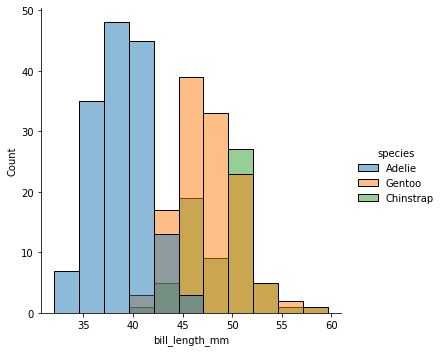

In [8]:
sns.displot(data=penguins_data, x='bill_length_mm', hue='species')

### Q2: Find the mean bill length for the whole population and the mean bill lengths for each species.

In [9]:
penguins_data.loc[:, 'bill_length_mm'].describe()

count    342.000000
mean      43.921930
std        5.459584
min       32.100000
25%       39.225000
50%       44.450000
75%       48.500000
max       59.600000
Name: bill_length_mm, dtype: float64

In [10]:
penguins_data.groupby('species').mean()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
species,,,,,
Adelie,38.791391,18.346358,189.953642,3700.662252,2008.013158
Chinstrap,48.833824,18.420588,195.823529,3733.088235,2007.970588
Gentoo,47.504878,14.982114,217.186992,5076.016260,2008.080645
